# Digital Signal and Image Management - Speaker recognition

Master's Degree in Data Science (A.Y. 2021/2022)

Autori: Silvia Ranieri, 
Raffaele Moretti,
Mattia Boller


# Libraries

In [ ]:
#regular expressions
import regex as re

#manipulate paths
import os

#audio segmentation
from pydub import AudioSegment
from pydub.utils import make_chunks
from scipy.io import wavfile as wav

#Audio utilities libraries
from scipy.io import wavfile as wav
import librosa
import sounddevice as sd
import IPython.display as ipd

#sklearn utilities 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

#keras for modeling
import keras
from keras import Sequential
from keras.utils import np_utils
from keras.losses import categorical_crossentropy
from sklearn.preprocessing import LabelEncoder

from scipy.stats import mode

#numpy
import numpy as np

#plot libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import noisereduce as nr

from pickle import dump, load

# Files Reading and feauture extractor

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# MFCC feature extractor
def mfcc(input, rate=44100):
    mfcc = librosa.feature.mfcc(input*1.0, sr = rate) #-- Calcolo Coefficienti MFCC
    #-- Flatten into monodimensional vector for the SVM
    mfcc = mfcc.flatten()
    return mfcc

# Data loader
def load_data(dir='', chunk_len=1, rec_rate=44100, feature_extractor=identity, test_size=0.2, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir(dir)):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, audio = wav.read(dir + '/' + f)
            # Divide recording into smaller audios
            chunks = make_chunks(audio, (chunk_len*rec_rate)) 
            # Compute all chunks except the last one that can be smaller than chunk_length_ms
            for chunk in chunks[0:-1]:
              cur_features = feature_extractor(np.array(chunk))
              features.append(cur_features)
              # Classes
              label = re.findall('_(.*)\.', f)[0]
              labels.append(label)

    return features, labels

# Splitting train-test

In [ ]:
# Load train data
x_train, y_train = load_data(dir='./data/audio/train', chunk_len=1, rec_rate=44100, feature_extractor=mfcc)

# Load test data
x_test, y_test = load_data(dir='./data/audio/test', chunk_len=1, rec_rate=44100, feature_extractor=mfcc)

In [ ]:
# Encode the labels in a format usable in a NN
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train = np_utils.to_categorical(y_train,3)
y_test = np_utils.to_categorical(y_test, 3)

In [ ]:
dump(encoder, open('labelEncoder.pkl', 'wb'))

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(1785, 1740)
(1785, 3)


# Build the model

In [ ]:
model = Sequential()
model.add(Dense(128,input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))
# compile: optimizer & losses/metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               222848    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 223,235
Trainable params: 223,235
Non-trainable params: 0
_________________________________________________________________


### Training and testing the model

In [ ]:
# Model training
history = model.fit(x_train, y_train, batch_size=64, validation_split=0.1, epochs=10)

Epoch 1/10
26/26 [==============================] - 3s 17ms/step - loss: 16.4369 - accuracy: 0.8188 - val_loss: 0.1128 - val_accuracy: 0.9777
Epoch 2/10
26/26 [==============================] - 0s 5ms/step - loss: 0.4741 - accuracy: 0.9608 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
26/26 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.9888 - val_loss: 1.6649e-08 - val_accuracy: 1.0000
Epoch 4/10
26/26 [==============================] - 0s 5ms/step - loss: 0.0348 - accuracy: 0.9956 - val_loss: 6.6597e-10 - val_accuracy: 1.0000
Epoch 5/10
26/26 [==============================] - 0s 5ms/step - loss: 0.0326 - accuracy: 0.9932 - val_loss: 2.6639e-09 - val_accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 0s 5ms/step - loss: 0.0275 - accuracy: 0.9956 - val_loss: 6.6597e-10 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 0s 5ms/step - loss: 0.0427 - accuracy: 0.9913 - val_loss: 3.3299e-09 - val_accuracy: 1

In [ ]:
score= model.evaluate(x_test, y_test, verbose=0)
print('Test score: ',score[0])
print('Test accuracy: ',score[1])

Test score:  0.0
Test accuracy:  1.0


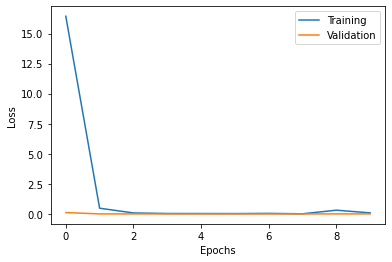

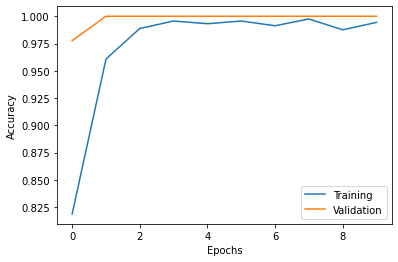

In [ ]:
# Plot training history
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

# Evaluation

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
print(classification_report(encoder.inverse_transform(np.argmax(y_test, axis=1)), encoder.inverse_transform(pred)))

              precision    recall  f1-score   support

      Mattia       1.00      1.00      1.00       599
    Raffaele       1.00      1.00      1.00       599
      Silvia       1.00      1.00      1.00       599

    accuracy                           1.00      1797
   macro avg       1.00      1.00      1.00      1797
weighted avg       1.00      1.00      1.00      1797



In [ ]:
model.save('speakerRecognitor.h5')

# Test model

In [ ]:
encoder = load(open('labelEncoder.pkl', 'rb'))

In [ ]:
model = keras.models.load_model('speakerRecognitor.h5')

In [ ]:
# Record audio
def rec_audio(duration=1, rec_rate=44100, chunk_len=1):
    rec = sd.rec(int(duration*rec_rate), samplerate=rec_rate, channels=1, blocking=True)
    recs = [mfcc(np.array(chunk.reshape(1,-1)[0])) for chunk in make_chunks(rec, (rec_rate*chunk_len))[0:-1]]
    return np.array(recs)

# Classification report

In [ ]:
# Test the model with multiple recordings and get a classification report
def test_speaker_rec(speaker_list=[], speaker='', model=model, n_tests=10):
  count = {person:0 for person in speaker_list}
  # Test the model
  for i in range(n_tests):
    print('Recording ' + str((i+1)) + '...')
    recs = rec_audio(duration=5, rec_rate=44100, chunk_len=1)
    print('Done!\n')
    pred = model.predict(recs)
    pred = encoder.inverse_transform(np.argmax(pred, axis=1))
    # Choose the most frequent prediction as speaker
    speaker_pred = mode(pred)[0][0]
    count[speaker_pred]+=1
  accuracy = count[speaker]/n_tests
  # Building the report
  report = 'Classification report \n\nSpeaker: ' + speaker +'\n\nPredicted: \n'
  for person in speaker_list:
    report = report + person + ': ' + str(count[person]) + '\n'
  report = report + '\nAccuracy = ' + str(accuracy)
  return report

In [ ]:
print(test_speaker_rec(speaker_list=['Mattia', 'Raffaele', 'Silvia'], model=model, speaker='Mattia', n_tests=10))

Recording 1...
Done!

Recording 2...
Done!

Recording 3...
Done!

Recording 4...
Done!

Recording 5...
Done!

Recording 6...
Done!

Recording 7...
Done!

Recording 8...
Done!

Recording 9...
Done!

Recording 10...
Done!

Classification report 

Speaker: Mattia

Predicted: 
Mattia: 10
Raffaele: 0
Silvia: 0

Accuracy = 1.0


In [ ]:
print(test_speaker_rec(speaker_list=['Mattia', 'Raffaele', 'Silvia'], model=model, speaker='Raffaele', n_tests=10))

Recording 1...
Done!

Recording 2...
Done!

Recording 3...
Done!

Recording 4...
Done!

Recording 5...
Done!

Recording 6...
Done!

Recording 7...
Done!

Recording 8...
Done!

Recording 9...
Done!

Recording 10...
Done!

Classification report 

Speaker: Raffaele

Predicted: 
Mattia: 0
Raffaele: 10
Silvia: 0

Accuracy = 1.0


In [ ]:
print(test_speaker_rec(speaker_list=['Mattia', 'Raffaele', 'Silvia'], model=model, speaker='Silvia', n_tests=10))

Recording 1...
Done!

Recording 2...
Done!

Recording 3...
Done!

Recording 4...
Done!

Recording 5...
Done!

Recording 6...
Done!

Recording 7...
Done!

Recording 8...
Done!

Recording 9...
Done!

Recording 10...
Done!

Classification report 

Speaker: Silvia

Predicted: 
Mattia: 0
Raffaele: 0
Silvia: 10

Accuracy = 1.0
